In [1]:
import sys

sys.argv = [""]
del sys

In [2]:
import cv2
import argparse
import numpy as np

import matplotlib.pyplot as plt

In [5]:
def create_cfg(args):
    parser = argparse.ArgumentParser()
    for key, val in args.items():
        parser.add_argument(key, default=val)

    cfg = parser.parse_args()
    return cfg

In [3]:
img = cv2.imread('C:/code/image-inpainting/samples/test/1_raw.png', cv2.IMREAD_COLOR)
mask = cv2.imread('C:/code/image-inpainting/samples/test/1_mask.png', cv2.IMREAD_COLOR)

In [4]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

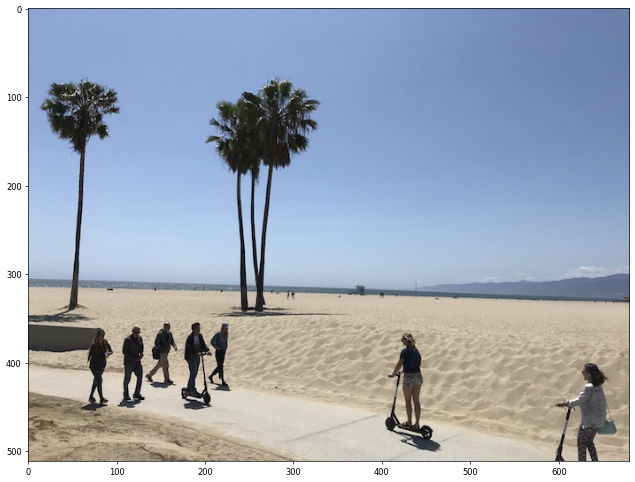

In [47]:
plt.figure(figsize=(20,10), dpi=60)
plt.imshow(img)

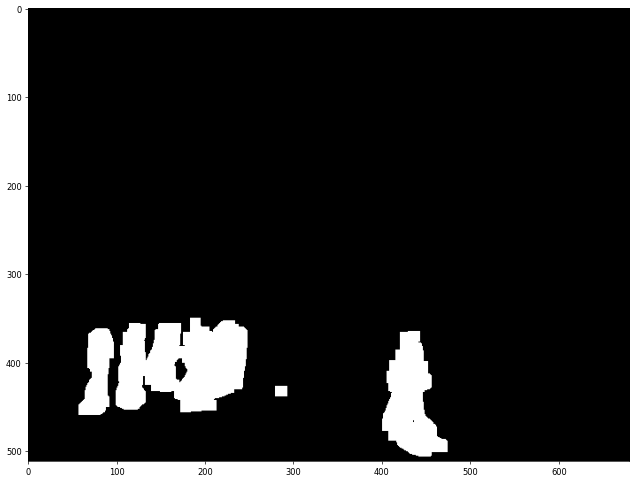

In [39]:
plt.figure(figsize=(20,10), dpi=60)
plt.imshow(mask)

In [51]:
maskk = mask[:,:,:1]
maskk.shape

(512, 680, 1)

___

Fix required: masked_image not displaying correctly 

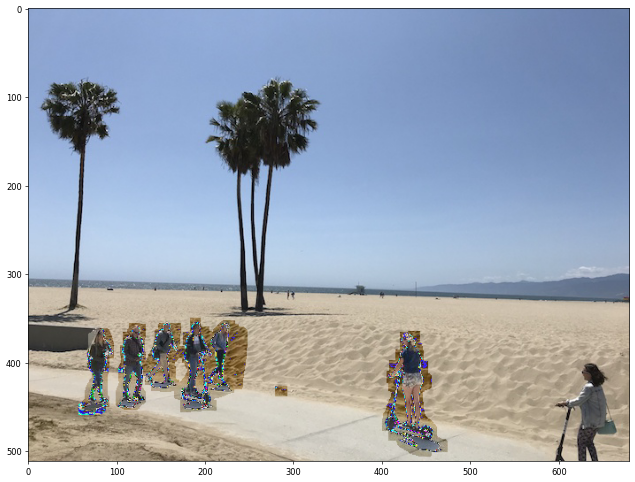

In [52]:
masked_img = img * (1 - maskk) + maskk
plt.figure(figsize=(20,10), dpi=60)
plt.imshow(masked_img)

___

1. load generator from best model checkpoint


In [2]:
from inpaint.core.generator import GatedGenerator

___
2. pass generator, img and mask to predict method
   img shape (3, H, W) and mask shape (1, H, W)

In [1]:
from inpaint.tools import predict

___
3. Visualize predicted image